### Calculations of Potential of Mean Force with Umbrella Sampling

In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import R

### The Folding of Alanine Dipeptide

<img src="fig/ad.png" align="center"/>

In [2]:
# Define the path to the data directory
_path = './project3-data/ala2_us_data/'

# Initialize lists to store trajectory data, bin centers, and force constants
trajs = []
bin_centers = []
force_constants = []

# Load trajectory data for 'a' series, from file index 45 to 75, in steps of 10
for i in range(45, 76, 10):

    trajs.append(np.loadtxt(_path + f'us-a-{i}_pullx.txt')[:, 1])
    bin_centers.append(i * 1e-2)
    force_constants.append(2000)

# Load trajectory data for 'b' series, similarly as for 'a' series
for i in range(45, 76, 10):

    trajs.append(np.loadtxt(_path + f'us-b-{i}_pullx.txt')[:, 1])
    bin_centers.append(i * 1e-2)
    force_constants.append(2000)

In [3]:
# Temperature in K
T = 298

 # unit of beta: 1/(kJ/mol)
beta = 1e3/(R*T)  

#### Calculate exp($-\beta_{i} * k_i * 1/2 *(x(t)-b_i)^2$)

In [4]:
def get_numerator(xt, force_constant, bin_center, beta):
    
    # Calculate the potential energy V, modeled as a harmonic potential
    v = force_constant * (xt - bin_center) ** 2 / 2
    
    # Return the exponential of the negative product of beta and the potential energy
    return np.exp(-beta * v)

In [5]:
def self_consistent_iteration(gen_func, f0, threshold=1e-3):
    
    # Initialize by generating the first new estimate using the provided function
    f_new = gen_func(f0)
    # Calculate the difference between the new estimate and the initial estimate
    diff = np.abs(f_new - f0)

    # Loop until all elements in the difference array are less than the threshold
    while np.any(diff > threshold):

        f0 = f_new.copy()
        f_new = gen_func(f0)
        diff = np.abs(f_new - f0)
        
        # Print the current estimate and its difference for monitoring
        print(f'{f0=}, {diff=}')

    # Return the new estimate after convergence
    return f_new

In [6]:
def solve_f(trajs, force_constants, bin_centers, beta, threshold):
    '''
    Self-consistently solve for f

    Parameters:
    - trajs: list of trajectory data arrays
    - force_constants: list of force constants for each trajectory
    - bin_centers: list of bin center positions for each trajectory
    - beta: inverse temperature factor (1/kT)
    - threshold: convergence threshold for self-consistent iteration

    Returns:
    - f: array of converged free energy estimates
    '''

    # Count the number of trajectories
    n_traj = len(trajs)
    # Calculate the total number of time steps in each trajectory
    tot_times = [traj.shape[0] for traj in trajs]

    def gen_new_f(f):
        # Initialize the summation array for new estimates
        s = np.zeros_like(f)

        # Iterate over all trajectories
        for k in range(n_traj):
            tot_time = tot_times[k]

            # Iterate over each time step in the trajectory
            for t in range(tot_time):
                x_kt = trajs[k][t]

                # Calculate the numerator for the kth trajectory at time t
                numerators = get_numerator(x_kt, force_constants, bin_centers, beta)
                # Calculate the denominator using all trajectories and their respective times
                denominator = np.sum(np.exp(f) * numerators * tot_times)

                # Accumulate the sum for the self-consistent field
                s += numerators / denominator

        # Return the negative logarithm of the summed terms, representing the new estimate of f
        return -np.log(s)
    
    # Use the self-consistent iteration function to find a converged solution for f
    f = self_consistent_iteration(gen_new_f, np.zeros(len(trajs)), threshold)
    
    return f

In [7]:
def create_pmf_bins(trajs, dx):
    '''
    Create bins for PMF (Potential of Mean Force) calculation based on the range of trajectory data.

    Parameters:
    - trajs: list of trajectory data arrays
    - dx: width of each bin

    Returns:
    - Array of bin edges
    '''

    # Find the minimum value from each trajectory and collect these into a list
    min_traj = [min(traj) for traj in trajs]
    # Find the maximum value from each trajectory and collect these into a list
    max_traj = [max(traj) for traj in trajs]

    # Determine the overall minimum value across all trajectories
    _min = min(min_traj)
    # Determine the overall maximum value across all trajectories
    _max = max(max_traj)

    # Create and return an array of bin edges from the minimum to the maximum value with each bin having width dx
    return np.arange(_min, _max + 2 * dx, dx)

### PMF: 

$-\beta A(\xi_k) = \ln \left( \sum_{j=1}^{J} c_{jk} \right) - \ln n - \ln \left( \sum_{j=1}^{J} e^{\eta_j(\xi_k) + \beta F_j} \right)$


In [8]:
def get_PMF(fs, trajs, force_constants, bin_centers, beta, dx=0.01):
    '''
    Calculate potential of mean force (PMF) using given trajectory data, free energy estimates, force constants, bin centers, and temperature factor beta.

    Parameters:
    - fs: array of free energy values for each trajectory
    - trajs: list of trajectory data arrays
    - force_constants: list of force constants for each trajectory
    - bin_centers: list of bin center positions for each trajectory
    - beta: inverse temperature factor (1/kT)
    - dx: width of each bin (default 0.01)

    Returns:
    - Tuple containing PMF values and corresponding bin centers
    '''

    # Create bins for PMF calculation from the trajectory data
    pmf_bins = create_pmf_bins(trajs, dx)
    # Determine the number of bins
    num_pmf_bins = len(pmf_bins) - 1

    # Count the number of trajectories and the total time steps in each trajectory
    n_traj = len(trajs)
    tot_times = [traj.shape[0] for traj in trajs]

    # Calculate the center of each bin
    pmf_bin_centers = np.array([(pmf_bins[i] + pmf_bins[i+1]) / 2 for i in range(num_pmf_bins)])

    # Initialize arrays to store exponential sums and count occurrences in each bin
    exp_bins = np.zeros(num_pmf_bins)
    count_bins = np.zeros(num_pmf_bins)

    # Iterate over all trajectories
    for k in range(n_traj):
        tot_time = tot_times[k]

        # Iterate over each time step in the trajectory
        for t in range(tot_time):
            x_kt = trajs[k][t]
            idx = np.digitize(x_kt, pmf_bins) - 1  # find the bin index for each trajectory point
            count_bins[idx] += 1

        # Calculate the weighted exponentials for the PMF bins using the current trajectory
        exp_bins += get_numerator(pmf_bin_centers, force_constants[k], bin_centers[k], beta) * np.exp(fs[k]) * tot_time

    # Compute the exponential PMF which is the ratio of counts to the weighted exponential terms
    exp_pmf = count_bins / exp_bins

    # Return the PMF values and their corresponding bin centers
    return -np.log(exp_pmf) / beta, pmf_bin_centers

### init: 0.4nm

In [9]:
fs = solve_f(trajs[:4], force_constants[:4], bin_centers[:4], beta, threshold=0.01)
pmf, pmf_center = get_PMF(fs, trajs[:4], force_constants[:4], bin_centers[:4], beta, dx=0.01)

f0=array([ 1.51707639, -0.51544975, -0.25925737,  0.21036424]), diff=array([0.5447395 , 0.24909288, 0.19291537, 0.07864739])
f0=array([ 2.06181589, -0.76454263, -0.45217275,  0.28901163]), diff=array([0.26459875, 0.0870373 , 0.14184716, 0.01091103])
f0=array([ 2.32641465, -0.85157993, -0.59401991,  0.29992266]), diff=array([0.15607779, 0.01197087, 0.10202561, 0.02474405])
f0=array([ 2.48249243, -0.8635508 , -0.69604551,  0.27517861]), diff=array([0.10701216, 0.0186863 , 0.07415003, 0.04212962])
f0=array([ 2.5895046 , -0.8448645 , -0.77019555,  0.23304898]), diff=array([0.08172422, 0.02990781, 0.05593169, 0.04918389])
f0=array([ 2.67122881, -0.81495669, -0.82612724,  0.1838651 ]), diff=array([0.06694818, 0.03297477, 0.04427137, 0.0506241 ])
f0=array([ 2.738177  , -0.78198192, -0.87039861,  0.133241  ]), diff=array([0.05724374, 0.0326562 , 0.03667661, 0.04917807])
f0=array([ 2.79542074, -0.74932572, -0.90707522,  0.08406292]), diff=array([0.05020346, 0.03097171, 0.03149651, 0.04637135])


C:\Users\jhyan\AppData\Local\Temp\ipykernel_22172\3615481195.py:35: RuntimeWarning: divide by zero encountered in log
  return -np.log(exp_pmf)/beta, pmf_bin_centers


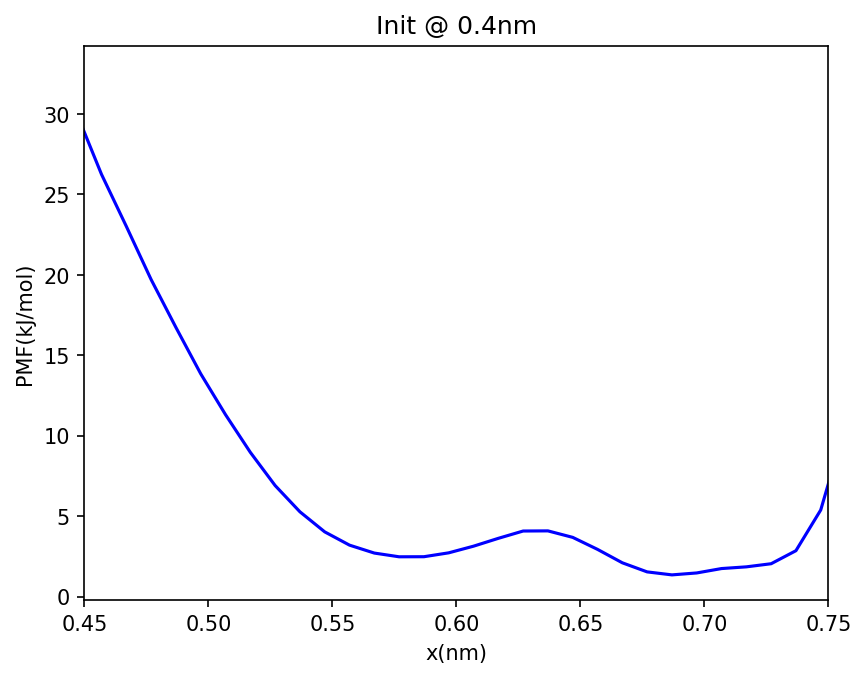

In [10]:
plt.figure(dpi=150)

plt.plot(pmf_center, pmf, color='blue')

plt.xlabel('x(nm)')
plt.ylabel('PMF(kJ/mol)')

plt.xlim(0.45,0.75)

plt.title('Init @ 0.4nm')

plt.show()

### init: 0.7nm

In [11]:
fs = solve_f(trajs[4:], force_constants[4:], bin_centers[4:], beta, threshold=0.01)
pmf, pmf_center = get_PMF(fs, trajs[4:], force_constants[4:], bin_centers[4:], beta, dx=0.01)

f0=array([ 1.51057034, -0.52286659, -0.25508896,  0.22091689]), diff=array([0.53432178, 0.25419439, 0.18844242, 0.08649146])
f0=array([ 2.04489212, -0.77706097, -0.44353137,  0.30740835]), diff=array([0.25493837, 0.09068694, 0.13755516, 0.0175078 ])
f0=array([ 2.29983049, -0.86774791, -0.58108654,  0.32491615]), diff=array([0.14781325, 0.01521968, 0.09804916, 0.01887545])
f0=array([ 2.44764374, -0.88296759, -0.67913569,  0.30604071]), diff=array([0.09997511, 0.01552401, 0.07053978, 0.03677246])
f0=array([ 2.54761885, -0.86744359, -0.74967548,  0.26926825]), diff=array([0.0756551 , 0.02682539, 0.05267876, 0.04424834])
f0=array([ 2.62327395, -0.84061819, -0.80235424,  0.22501991]), diff=array([0.06163477, 0.03002353, 0.04133641, 0.04607068])
f0=array([ 2.68490872, -0.81059466, -0.84369065,  0.17894923]), diff=array([0.05253219, 0.02987522, 0.03401419, 0.04498321])
f0=array([ 2.73744091, -0.78071944, -0.87770484,  0.13396602]), diff=array([0.04598475, 0.02837943, 0.0290667 , 0.04251407])


C:\Users\jhyan\AppData\Local\Temp\ipykernel_22172\3615481195.py:35: RuntimeWarning: divide by zero encountered in log
  return -np.log(exp_pmf)/beta, pmf_bin_centers


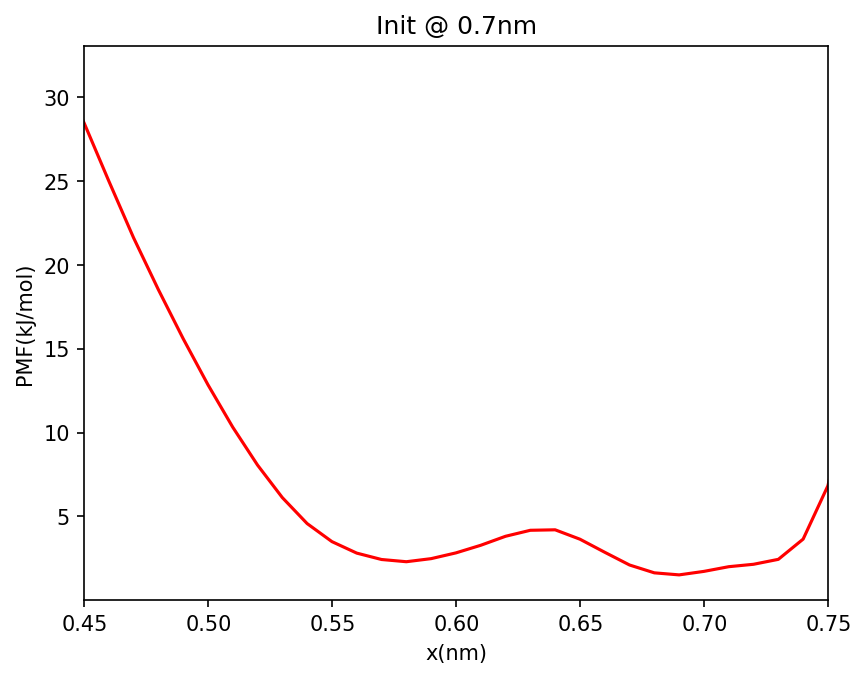

In [12]:
plt.figure(dpi=150)

plt.plot(pmf_center, pmf, color='red')

plt.xlabel('x(nm)')
plt.ylabel('PMF(kJ/mol)')

plt.xlim(0.45,0.75)

plt.title('Init @ 0.7nm')

plt.show()

### The Dimerization of Two Methanes in Water

<img src="fig/methane.png" align="center"/>

In [13]:
def read_trajectory_data(file_path):
    """
    Reads an XVG file and returns the data, specifically the second column which typically represents position data of the center of mass (COM).

    Parameters:
    - file_path: string path to the XVG file

    Returns:
    - numpy array of position data extracted from the second column of the XVG file
    """

    # Initialize an empty list to store the position COM data
    position = []
    
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Iterate over each line in the file
        for line in file:
            # Skip metadata lines that start with '@' or '#'
            if line.startswith(('@', '#')):
                continue

            # Split the line into columns (assuming whitespace separation)
            columns = line.split()
            
            # Append the second column to the position list, converting it to float
            position.append(float(columns[1]))
    
    # Convert the list to a NumPy array for easy manipulation and return it
    return np.array(position)

In [14]:
# Define the path to the data directory
_path = './project3-data/methane_us_data/'

# Initialize lists to store trajectory data, bin centers, and force constants
trajs = []
bin_centers = []
force_constants = []

# Load trajectory data for windows 4 through 11, settings for 'a' series
for i in range(4, 12):

    trajs.append(read_trajectory_data(_path + f'a{i}_pullx.xvg'))
    bin_centers.append(i * 1e-1)
    force_constants.append(1000)

# Repeat the same loading process for windows 4 through 11, identical settings and files
for i in range(4, 12):

    trajs.append(read_trajectory_data(_path + f'a{i}_pullx.xvg'))
    bin_centers.append(i * 1e-1)
    force_constants.append(1000)

### init: 0.3nm

In [15]:
fs = solve_f(trajs[:8], force_constants[:8], bin_centers[:8], beta, threshold=0.01)
pmf, pmf_center = get_PMF(fs, trajs[:8], force_constants[:8], bin_centers[:8], beta, dx=0.01)

f0=array([-0.06493313,  0.06326964,  0.15277928, -0.06173848, -0.02726972,
        0.0145453 , -0.00796311, -0.04976008]), diff=array([0.03215201, 0.0434526 , 0.08220178, 0.01020889, 0.02411841,
       0.00017717, 0.01260416, 0.04040042])
f0=array([-0.09708514,  0.10672224,  0.23498107, -0.07194737, -0.05138813,
        0.01436813, -0.02056727, -0.0901605 ]), diff=array([0.01232561, 0.02978545, 0.05225935, 0.00630409, 0.01483589,
       0.0081234 , 0.01616252, 0.03415899])
f0=array([-0.10941075,  0.13650769,  0.28724042, -0.06564328, -0.06622402,
        0.00624473, -0.03672978, -0.12431949]), diff=array([0.00107101, 0.02244924, 0.03677312, 0.01130027, 0.00803604,
       0.01123557, 0.01837481, 0.03009983])
f0=array([-0.11048176,  0.15895693,  0.32401354, -0.05434301, -0.07426005,
       -0.00499084, -0.05510459, -0.15441933]), diff=array([0.00529508, 0.01869081, 0.02781007, 0.01225764, 0.00399851,
       0.01199353, 0.01933895, 0.027429  ])
f0=array([-0.10518668,  0.17764774,  0.35182

C:\Users\jhyan\AppData\Local\Temp\ipykernel_22172\3615481195.py:35: RuntimeWarning: divide by zero encountered in log
  return -np.log(exp_pmf)/beta, pmf_bin_centers


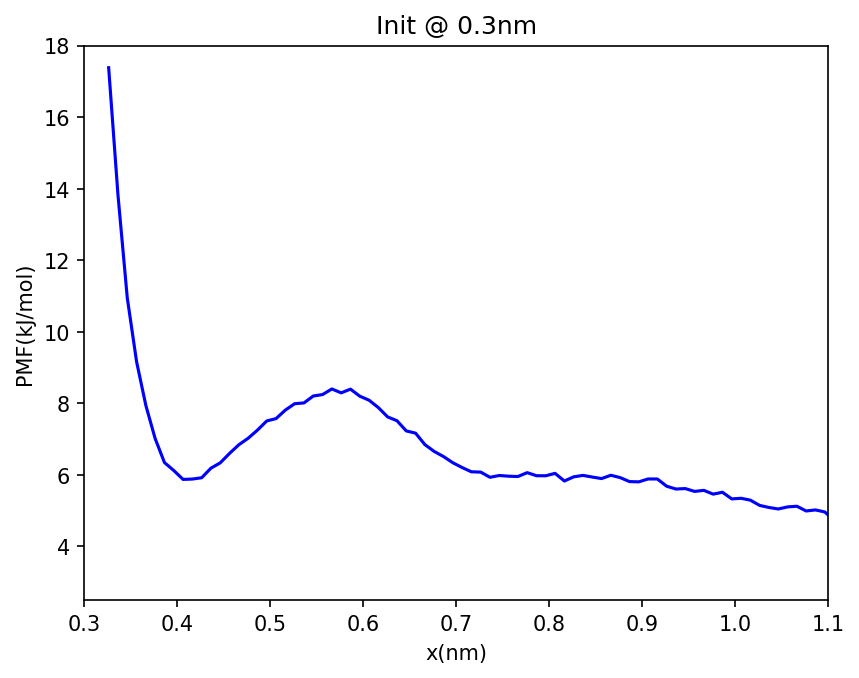

In [16]:
plt.figure(dpi=150)

plt.plot(pmf_center, pmf, color='blue')

plt.xlabel('x(nm)')
plt.ylabel('PMF(kJ/mol)')

plt.xlim(0.3,1.1)
plt.ylim(2.5,18)

plt.title('Init @ 0.3nm')

plt.show()

### init: 1.2nm

In [17]:
fs = solve_f(trajs[8:], force_constants[8:], bin_centers[8:], beta, threshold=0.01)
pmf, pmf_center = get_PMF(fs, trajs[8:], force_constants[8:], bin_centers[8:], beta, dx=0.01)

f0=array([-0.06493313,  0.06326964,  0.15277928, -0.06173848, -0.02726972,
        0.0145453 , -0.00796311, -0.04976008]), diff=array([0.03215201, 0.0434526 , 0.08220178, 0.01020889, 0.02411841,
       0.00017717, 0.01260416, 0.04040042])
f0=array([-0.09708514,  0.10672224,  0.23498107, -0.07194737, -0.05138813,
        0.01436813, -0.02056727, -0.0901605 ]), diff=array([0.01232561, 0.02978545, 0.05225935, 0.00630409, 0.01483589,
       0.0081234 , 0.01616252, 0.03415899])
f0=array([-0.10941075,  0.13650769,  0.28724042, -0.06564328, -0.06622402,
        0.00624473, -0.03672978, -0.12431949]), diff=array([0.00107101, 0.02244924, 0.03677312, 0.01130027, 0.00803604,
       0.01123557, 0.01837481, 0.03009983])
f0=array([-0.11048176,  0.15895693,  0.32401354, -0.05434301, -0.07426005,
       -0.00499084, -0.05510459, -0.15441933]), diff=array([0.00529508, 0.01869081, 0.02781007, 0.01225764, 0.00399851,
       0.01199353, 0.01933895, 0.027429  ])
f0=array([-0.10518668,  0.17764774,  0.35182

C:\Users\jhyan\AppData\Local\Temp\ipykernel_22172\3615481195.py:35: RuntimeWarning: divide by zero encountered in log
  return -np.log(exp_pmf)/beta, pmf_bin_centers


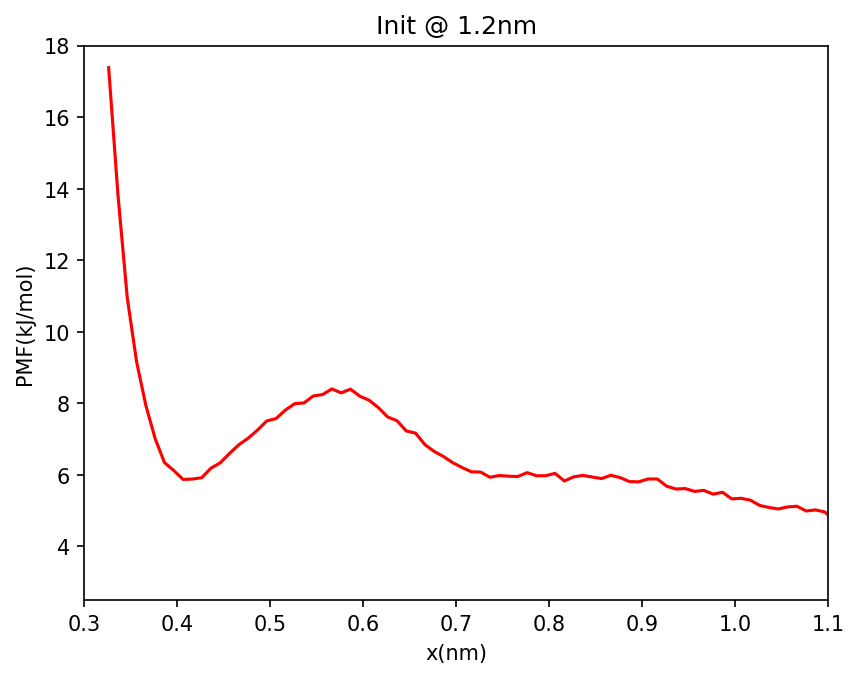

In [18]:
plt.figure(dpi=150)

plt.plot(pmf_center, pmf, color='red')

plt.xlabel('x(nm)')
plt.ylabel('PMF(kJ/mol)')

plt.xlim(0.3,1.1)
plt.ylim(2.5,18)

plt.title('Init @ 1.2nm')

plt.show()

### Write Configuration Files for Umbrella Sampling Simulations of GROMACS

<img src="fig/ad_us.png" align="center"/>


<img src="fig/methane_us.png" align="center"/>